# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет. 

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('content/persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [4]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

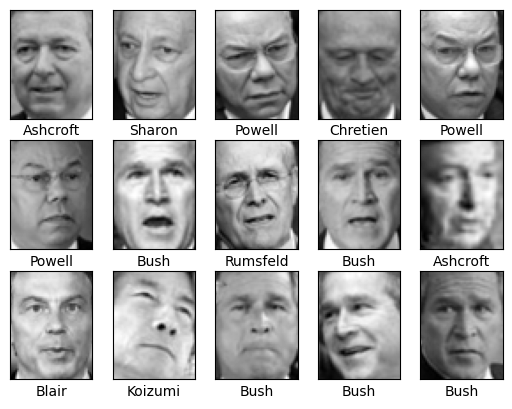

In [7]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Крупнее

(-0.5, 46.5, 61.5, -0.5)

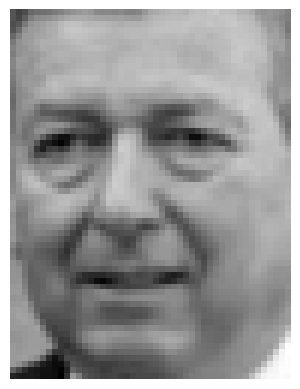

In [8]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [12]:
len(set(df.label))

12

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

In [35]:
df_by_person = {}
for name in set(df.label):
    df_by_person[name] = df[df.label == name].drop("label", axis=1)

In [36]:
df_by_person_percentage = { name : array.shape[0]/df.shape[0] for name, array in df_by_person.items()}

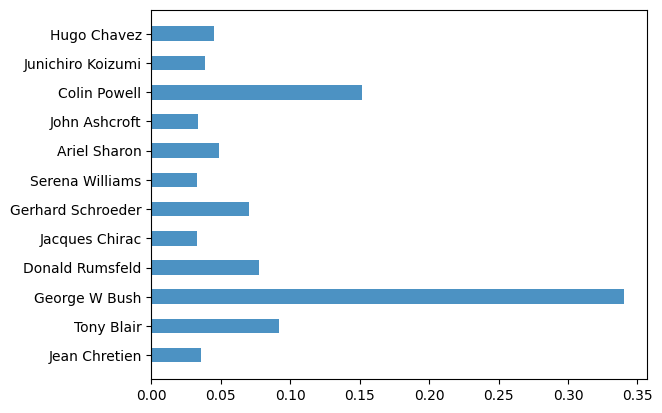

In [37]:
plt.barh(list(df_by_person_percentage.keys()), list(df_by_person_percentage.values()), linewidth=1, alpha=0.8, height=0.5)
None

In [38]:
print(df_by_person_percentage)

{'Jean Chretien': 0.03544494720965309, 'Tony Blair': 0.09200603318250378, 'George W Bush': 0.3401206636500754, 'Donald Rumsfeld': 0.07767722473604827, 'Jacques Chirac': 0.033182503770739065, 'Gerhard Schroeder': 0.07013574660633484, 'Serena Williams': 0.033182503770739065, 'Ariel Sharon': 0.049019607843137254, 'John Ashcroft': 0.033936651583710405, 'Colin Powell': 0.1515837104072398, 'Junichiro Koizumi': 0.038461538461538464, 'Hugo Chavez': 0.04524886877828054}


На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [81]:
df_by_person_mean_vector = {name : vectors.mean(axis=0).astype(float).to_numpy() for name, vectors in df_by_person.items()}

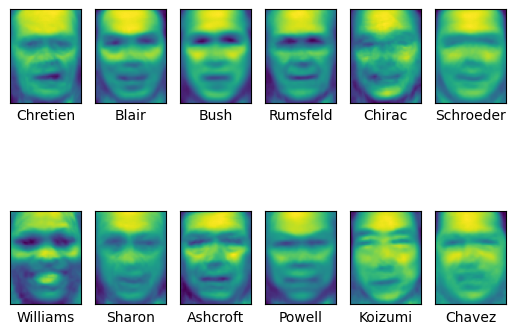

In [82]:
labels = list(df_by_person_mean_vector.keys())

fig, ax = plt.subplots(2, 6)
for i, axi in enumerate(ax.flat):
    lbl = labels[i]
    img = df_by_person_mean_vector[lbl].reshape(62,47)
    axi.imshow(img)
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [71]:
df_by_person_mean_vector['Gerhard Schroeder'][0][0]

0.21016234977419354

Используя усредненные векторы, постройте изображения всех людей из набора данных.

In [ ]:
# < ENTER YOUR CODE HERE > 

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [93]:
import numpy as np
import seaborn as sns

sns.set_style('white')

<Axes: >

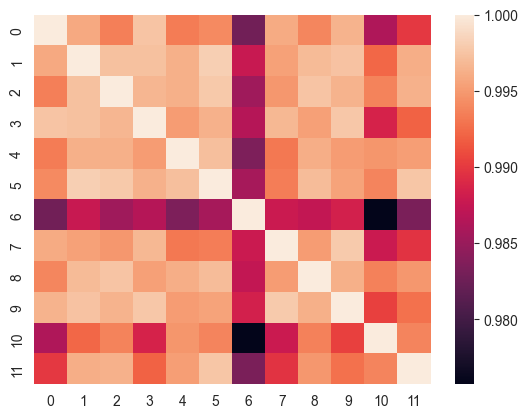

In [94]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(np.array(list(df_by_person_mean_vector.values())))
sns.heatmap(similarity_matrix)

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [101]:
list(df_by_person_mean_vector.keys()).index('Gerhard Schroeder')

5

In [102]:
list(df_by_person_mean_vector.keys()).index('Hugo Chavez')

11

In [103]:
similarity_matrix[5][11]

0.9976209981219303

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [ ]:
# < ENTER YOUR CODE HERE > 

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
# < ENTER YOUR CODE HERE > 

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
# < ENTER YOUR CODE HERE > 

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [ ]:
# < ENTER YOUR CODE HERE > 

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE > 

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [ ]:
# < ENTER YOUR CODE HERE > 

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [ ]:
# < ENTER YOUR CODE HERE > 

Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [ ]:
# < ENTER YOUR CODE HERE > 

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [ ]:
# < ENTER YOUR CODE HERE > 

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE > 

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
# < ENTER YOUR CODE HERE > 

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.